In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
import os
from tqdm.notebook import tqdm

from PIL import Image

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
PyTorch version 2.4.0+cpu
Torchvision version 0.19.0+cpu
Numpy version 1.26.4
Pandas version 2.2.2


# CSV Cleansing

In [2]:
csv_path='/kaggle/input/fundusimage/ocular-disease-recognition-odir5k/full_df.csv'

In [3]:
csv = pd.read_csv(csv_path)
csv.shape


(6392, 19)

In [4]:
csv.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Dataset

In [5]:
train_path='/kaggle/input/fundusimage/ocular-disease-recognition-odir5k/ODIR-5K/Training Images'
test_path='/kaggle/input/fundusimage/ocular-disease-recognition-odir5k/ODIR-5K/Testing Images'

In [6]:
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']


In [7]:
IMAGE_SIZE = 224
data_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))])
# data_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
#                                              transforms.ToTensor()])

In [8]:
class OcularDiseaseDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file) 
        self.transform = transform 

    def __len__(self):
        return len(self.df)  

    def __getitem__(self, index):
        image_path = self.df.filepath[index].replace('../input', '/kaggle/input/fundusimage')
        image = Image.open(image_path)
        label = self.df.labels[index]
        label = label.strip("[]").strip("'\"")

        if self.transform:
            image = self.transform(image)
        return image, label


In [9]:
train_dataset = OcularDiseaseDataset(
    csv_path,
    data_transform
)

In [10]:
len(train_dataset)

6392

In [11]:
train_dataset.__getitem__(2)

(<PIL.Image.Image image mode=RGB size=224x224>, 'D')

D


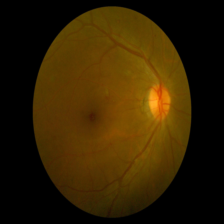

In [12]:
image, label = train_dataset[2]
print(label)
image

In [13]:
target_to_class = {
    'N': 'Normal',
    'D': 'Diabetes',
    'G': 'Glaucoma',
    'C': 'Cataract',
    'A': 'Age-related Macular Degeneration',
    'H': 'Hypertension',
    'M': 'Pathological Myopia',
    'O': 'Other diseases/abnormalities'
}

In [14]:
target_to_class[label]

'Diabetes'